<a href="https://colab.research.google.com/github/lukas1326/Sentiment_analysis/blob/master/Sentiment_analysis_EDA_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import csv
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import string
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
import nltk
from sklearn.svm import SVC

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/My Drive/Colab Notebooks/sentiment_analysis

/content/drive/My Drive/Colab Notebooks/sentiment_analysis


In [4]:
filename ='Dataset.csv'

In [5]:
with open(filename, "r",errors='ignore') as file:
    reader = csv.DictReader(file,delimiter='|')
    rows = list(reader)

In [6]:
df = pd.DataFrame(rows)

In [7]:
df.head()

,label,text
0,5,It's Tim Ferriss. Extracting value that you a...
1,3,"Good reviews, but not what I expected. Overall..."
2,5,Tim Ferriss a rapidly evolving meta human/mut...
3,5,Anything Tim Ferriss I will buy. Podcasts are ...
4,3,Love the authors podcasts and the book is ever...


In [8]:
df.groupby('label').count()

,text
label,
1,1791
2,1797
3,3807
4,8872
5,47255


In [9]:
df.shape

(63522, 2)

In [10]:
df.drop(df[df.label=='3'].index, inplace=True)


Rarrange labels in binary. 5,4 into 0 - positive, 1,2 into 1 - negative. Label 3- dropped.

In [11]:
df.loc[(df.label=='5')|(df.label=='4'),'label']=0

In [12]:
df.loc[(df.label=='1')|(df.label=='2'),'label']=1

Imbalanced labels

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


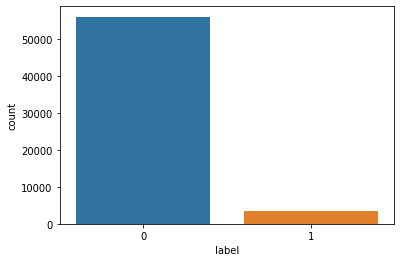

In [13]:
sns.countplot(df['label'], label = 'Count')

In [14]:
df['length'] = df['text'].apply(len)

In [15]:
positive = df[df.label==0]
negative=df[df.label==1]

In [16]:
# проверить значима ли разница между средней длиной текста позитивных отзывов и негативных
from scipy import stats
stats.ttest_ind(positive.length, negative.length, equal_var=False)

Ttest_indResult(statistic=-9.468825083098423, pvalue=4.789870739073252e-21)

In [17]:
pos_sent = positive['text'].tolist()
pos_as_one = " ".join(pos_sent)

In [18]:
neg_sent = negative['text'].tolist()
neg_as_one = " ".join(neg_sent)

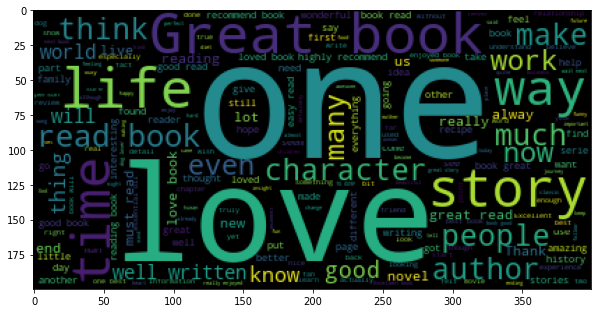

In [19]:
plt.figure(figsize=(10,10))
plt.imshow(WordCloud().generate(pos_as_one))

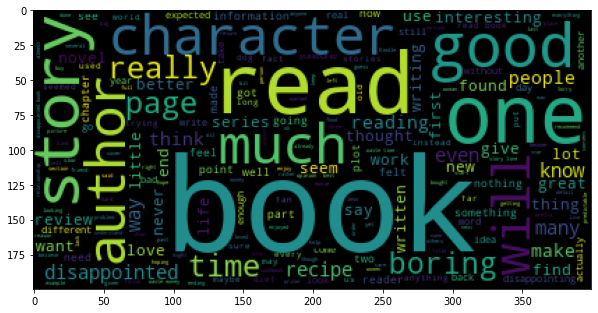

In [20]:
plt.figure(figsize=(10,10))
plt.imshow(WordCloud().generate(neg_as_one))

Add features

In [21]:
df['capitals'] = df['text'].apply(lambda text: sum(1 for c in text if c.isupper()))

In [22]:
df['caps_vs_length'] = df.apply(lambda row: float(row['capitals'])/float(row['length']),axis=1)

In [23]:
df['num_exclamation_marks'] = df['text'].apply(lambda text: text.count('!'))

In [24]:
df['num_punctuation'] = df['text'].apply(lambda text: sum(text.count(w) for w in '.,;:'))

In [25]:
df['num_smilies'] = df['text'].apply(lambda text: sum(text.count(w) for w in (':-)', ':)', ';-)', ';)')))

In [26]:
df

,label,text,length,capitals,caps_vs_length,num_exclamation_marks,num_punctuation,num_smilies
0,0,It's Tim Ferriss. Extracting value that you a...,122,6,0.049180,0,4,0
2,0,Tim Ferriss a rapidly evolving meta human/mut...,398,14,0.035176,0,9,0
3,0,Anything Tim Ferriss I will buy. Podcasts are ...,177,6,0.033898,0,4,0
5,0,Awesome and practical!,22,1,0.045455,1,0,0
6,0,What an incredible book!,24,1,0.041667,1,0,0
...,...,...,...,...,...,...,...,...
63516,0,It was a great way to end the trilogy! Awesome...,52,2,0.038462,1,1,0
63517,0,I enjoyed reading this book but felt the first...,134,2,0.014925,0,3,0
63519,0,Way better than the movie!,26,1,0.038462,1,0,0
63520,0,Great paperback set. Comes with a cardboard co...,90,2,0.022222,0,2,0


In [27]:
features = ('length', 'capitals', 'caps_vs_length', 'num_exclamation_marks','num_punctuation','num_smilies')
columns = ('length', 'capitals', 'caps_vs_length', 'num_exclamation_marks','num_punctuation','num_smilies')
rows = [{c:df[f].corr(df[c]) for c in columns} for f in features]
df_correlations = pd.DataFrame(rows, index=features)

For correlation between generated features explore

In [28]:
df_correlations

,length,capitals,caps_vs_length,num_exclamation_marks,num_punctuation,num_smilies
length,1.000000,0.754516,-0.106352,0.112985,0.939251,0.039156
capitals,0.754516,1.000000,0.202622,0.193422,0.735090,0.036099
caps_vs_length,-0.106352,0.202622,1.000000,0.047999,-0.094695,-0.009876
num_exclamation_marks,0.112985,0.193422,0.047999,1.000000,0.070911,0.044736
num_punctuation,0.939251,0.735090,-0.094695,0.070911,1.000000,0.045704
num_smilies,0.039156,0.036099,-0.009876,0.044736,0.045704,1.000000


In [32]:
df['label']=df['label'].astype('int64') # change label type

In [37]:
# cleaning and stemming text 
stemmer = PorterStemmer()
df['text'] = df['text'].apply(lambda x: " ".join([stemmer.stem(i) for i in re.sub("[^a-zA-Z]", " ", x).split()]).lower())

In [38]:
df['text'][:10]

0     it s tim ferriss extract valu that you and i n...
2     tim ferriss a rapidli evolv meta human mutant ...
3     anyth tim ferriss i will buy podcast are aweso...
5                                    awesom and practic
6                                   what an incred book
7     good book that i did like read i do wish he we...
8     finish the book recent and i will definit go b...
9     thi is an awesom easi to read book i ve given ...
11    thi book is not what it appear to be if you ar...
12    great book i have been wait for thi book i bro...
Name: text, dtype: object

In [39]:
# train, valid, test split
x, x_test, y, y_test = train_test_split(df.loc[:, df.columns != 'label'],df.label,test_size=0.2,train_size=0.8)
x_train, x_val, y_train, y_val = train_test_split(x,y,test_size = 0.25,train_size =0.75)


In [50]:
del df

In [40]:
# data standardization with  sklearn


# copy of datasets
x_train_stand = x_train.copy()
x_test_stand = x_test.copy()
x_val_stand = x_val.copy()

# numerical features
num_cols = ['length', 'capitals','caps_vs_length','num_exclamation_marks','num_punctuation','num_smilies']

# apply standardization on numerical features
for i in num_cols:
    
    # fit on training data column
    scale = StandardScaler().fit(x_train_stand[[i]])
    
    # transform the training data column
    x_train_stand[i] = scale.transform(x_train_stand[[i]])
    
    # transform the testing data column
    x_test_stand[i] = scale.transform(x_test_stand[[i]])
    # transform the validation data column
    x_val_stand[i] = scale.transform(x_val_stand[[i]])

In [41]:
# map vectorized data and feature columns
mapper = DataFrameMapper([
    (['length', 'capitals','caps_vs_length','num_exclamation_marks','num_punctuation','num_smilies'], None),
    ('text',TfidfVectorizer(stop_words='english', max_df=0.7))
])

In [42]:
mapper.fit(x_train_stand)

DataFrameMapper(default=False, df_out=False,
                features=[(['length', 'capitals', 'caps_vs_length',
                            'num_exclamation_marks', 'num_punctuation',
                            'num_smilies'],
                           None),
                          ('text',
                           TfidfVectorizer(analyzer='word', binary=False,
                                           decode_error='strict',
                                           dtype=<class 'numpy.float64'>,
                                           encoding='utf-8', input='content',
                                           lowercase=True, max_df=0.7,
                                           max_features=None, min_df=1,
                                           ngram_range=(1, 1), norm='l2',
                                           preprocessor=None, smooth_idf=True,
                                           stop_words='english',
                                           strip_

In [43]:
# map standardizated trained and validation columns 
xtrain_trans = mapper.transform(x_train_stand)
xval_trans = mapper.transform(x_val_stand)

In [44]:
# check the shape
xtrain_trans.shape,xval_trans.shape

((35829, 19679), (11943, 19679))

In [ ]:
# haven't run because of memory run out
#clf_3 = SVC(kernel='linear', 
            #class_weight='balanced', # penalize
            #probability=True)
#model = clf_3.fit(xtrain_trans, y_train)
#print(metrics.classification_report(y_val, model.predict(xval_trans)))

In [45]:
# model performance with class_wight parameter in case dealing with imbalanced data set
model = linear_model.LogisticRegression(class_weight='balanced').fit(xtrain_trans, y_train)
print(metrics.classification_report(y_val, model.predict(xval_trans)))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              precision    recall  f1-score   support

           0       0.99      0.91      0.95     11195
           1       0.38      0.80      0.51       748

    accuracy                           0.90     11943
   macro avg       0.68      0.85      0.73     11943
weighted avg       0.95      0.90      0.92     11943

